In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

import joblib

In [ ]:
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Energy Forecasting/data")

In [ ]:
data = pd.read_csv(data_dir / "demand.csv")
demand_data = data[['datetime', 'Demand (MW)']].copy()
demand_data.head()

,datetime,Demand (MW)
0,2020-01-01 00:00:00,445.8
1,2020-01-01 01:00:00,424.5
2,2020-01-01 02:00:00,423.5
3,2020-01-01 03:00:00,418.8
4,2020-01-01 04:00:00,414.8


In [ ]:
demand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27723 entries, 0 to 27722
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     27723 non-null  object 
 1   Demand (MW)  27555 non-null  float64
dtypes: float64(1), object(1)
memory usage: 433.3+ KB


In [ ]:
demand_data["datetime"] = pd.to_datetime(demand_data["datetime"])
# convert the datetime into the hourly period
demand_data["datetime"] = demand_data["datetime"].dt.to_period("H")
demand_data = demand_data.set_index("datetime")

In [ ]:
display(demand_data.head())
display(demand_data.tail())

,Demand (MW)
datetime,
2020-01-01 00:00,445.8
2020-01-01 01:00,424.5
2020-01-01 02:00,423.5
2020-01-01 03:00,418.8
2020-01-01 04:00,414.8


,Demand (MW)
datetime,
2023-02-28 19:00,NaN
2023-02-28 20:00,NaN
2023-02-28 21:00,NaN
2023-02-28 22:00,NaN
2023-02-28 23:00,NaN


In [ ]:
train_data = demand_data.dropna().copy()
test_data = demand_data[demand_data.isnull().any(axis=1)].copy()
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 27555 entries, 2020-01-01 00:00 to 2023-02-21 23:00
Freq: H
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand (MW)  27555 non-null  float64
dtypes: float64(1)
memory usage: 430.5 KB
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 168 entries, 2023-02-22 00:00 to 2023-02-28 23:00
Freq: H
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand (MW)  0 non-null      float64
dtypes: float64(1)
memory usage: 2.6 KB


In [ ]:
train_data.head()

,Demand (MW)
datetime,
2020-01-01 00:00,445.8
2020-01-01 01:00,424.5
2020-01-01 02:00,423.5
2020-01-01 03:00,418.8
2020-01-01 04:00,414.8


## Check stationarity in the training data

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_data["Demand (MW)"])

(-10.357108761265218,
 2.4503175782482186e-18,
 48,
 27506,
 {'1%': -3.430587763047038,
  '5%': -2.861645084490038,
  '10%': -2.5668259333281167},
 211142.01723298524)

H0: The time series is non-stationary. In other words, it has some time-dependent structure and doesn't have constant variance over time.

H1: The time series is stationary

If the p-value from the ADF test is less than some significant level(e.g alpha = 0.05), then we can reject the null hypothesis and conclude that the time series is stationary.

**Conclusion**
From the above ADF test, we can obsere p-value = 2.45 * 10^(-18) which is less than 0.05, hence Null hypothesis is rejected. So, there is possibility that the time series is stationarity.

In [ ]:
p

## ACF and PACF Plots

In [ ]:
def plot_acf_pacf_graphs(X=None, lags=48, title="PACF plot"):
    """ Plot the PACF and ACF graphs for the time series data X

    Args:
        X (np.array): Time-series data
    """
    fig = plt.figure(figsize=(9, 5))
    fig.subplots_adjust(hspace=0.5)

    # ACF plot
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(X, ax=ax1, lags=lags)
    ax1.set_title(f"Autocorrelation plot for {title}")

    # PACF plot
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(X, ax=ax2, lags=lags)
    ax2.set_title(f"PACF plot for {title}")
    plt.show()

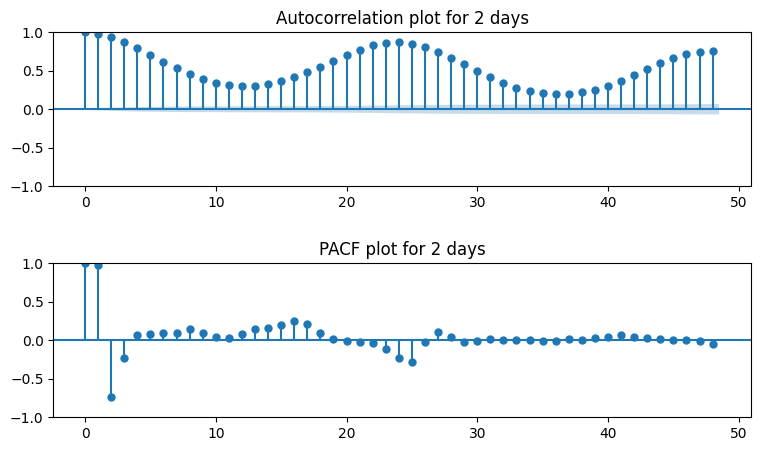

In [ ]:
X_tmp = train_data.reset_index()
plot_acf_pacf_graphs(X=X_tmp["Demand (MW)"], lags=48, title="2 days")

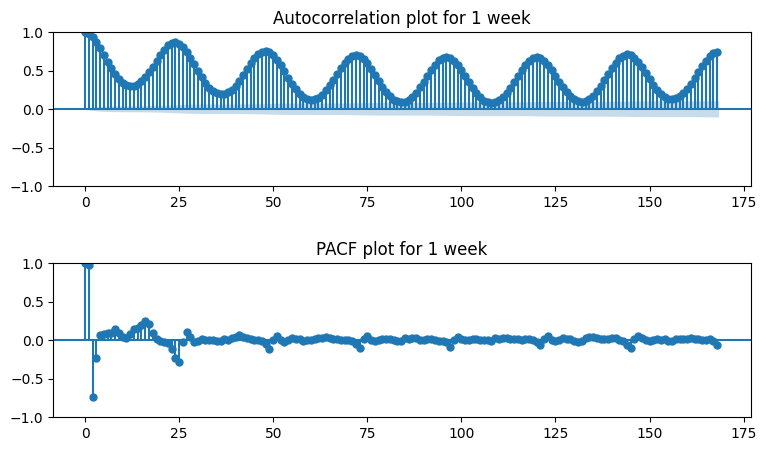

In [ ]:
X_tmp = train_data.reset_index()
plot_acf_pacf_graphs(X=X_tmp["Demand (MW)"], lags=168, title="1 week")

From ACF and PACF plot, we can observe, most of the correlation lies outside the confidence region.

PACF values that lies outside the confidence region are considered statistically significant.

In [ ]:
X = train_data.copy()
X.head()

,Demand (MW)
datetime,
2020-01-01 00:00,445.8
2020-01-01 01:00,424.5
2020-01-01 02:00,423.5
2020-01-01 03:00,418.8
2020-01-01 04:00,414.8


In [ ]:
def make_lags(df, column_to_lag = "Demand (MW)", no_of_lags = 504):
  lagged_columns = []

  for i in range(1, no_of_lags + 1):
    lagged_columns.append(df[column_to_lag].shift(i).rename(f"lag_{i}"))
  df_lags = pd.concat([df] + lagged_columns, axis = 1)
  return df_lags

In [ ]:
X_lagged = make_lags(X, column_to_lag = "Demand (MW)", no_of_lags = 504)
X_lagged.head()

,Demand (MW),lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,lag_501,lag_502,lag_503,lag_504
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00,445.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00,424.5,445.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00,423.5,424.5,445.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00,418.8,423.5,424.5,445.8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00,414.8,418.8,423.5,424.5,445.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_lagged = X_lagged.dropna()
X_lagged.head()

,Demand (MW),lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,lag_501,lag_502,lag_503,lag_504
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-22 00:00,592.5,619.9,638.9,665.4,661.5,661.4,640.0,611.1,590.5,596.2,...,447.8,453.5,446.8,436.8,432.1,414.8,418.8,423.5,424.5,445.8
2020-01-22 01:00,588.1,592.5,619.9,638.9,665.4,661.5,661.4,640.0,611.1,590.5,...,446.1,447.8,453.5,446.8,436.8,432.1,414.8,418.8,423.5,424.5
2020-01-22 02:00,587.4,588.1,592.5,619.9,638.9,665.4,661.5,661.4,640.0,611.1,...,443.8,446.1,447.8,453.5,446.8,436.8,432.1,414.8,418.8,423.5
2020-01-22 03:00,587.0,587.4,588.1,592.5,619.9,638.9,665.4,661.5,661.4,640.0,...,441.4,443.8,446.1,447.8,453.5,446.8,436.8,432.1,414.8,418.8
2020-01-22 04:00,590.3,587.0,587.4,588.1,592.5,619.9,638.9,665.4,661.5,661.4,...,433.4,441.4,443.8,446.1,447.8,453.5,446.8,436.8,432.1,414.8


In [ ]:
X = X_lagged.drop(["Demand (MW)"], axis = 1)
y = X_lagged["Demand (MW)"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 168, shuffle=False)

In [ ]:
X_train.shape, X_test.shape

((26883, 504), (168, 504))

**The model training took about 22 minutes as shown below with n_estimators = 100 in google colab**

In [ ]:
model_rf = RandomForestRegressor(n_estimators = 100, verbose=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.0min finished


RandomForestRegressor(n_jobs=-1, verbose=1)

In [ ]:
save_model = True
if save_model:
  joblib.dump(model_rf, data_dir / "rf_model.pkl")

## Testing the model

In [ ]:
loaded_model=joblib.load(data_dir / "rf_model.pkl")

In [ ]:
X_test.shape, y_test.shape

((168, 504), (168,))

In [ ]:
y_train_forecast = loaded_model.predict(X_train)
y_test_forecast = loaded_model.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
print(mean_squared_error(y_train, y_train_forecast))
print(mean_squared_error(y_test, y_test_forecast))

18.534344534612956
124.63207328571434


In [ ]:
def plot_truth_vs_pred(y_test, y_pred, number_to_plot = 50):
  pred_df = pd.DataFrame({"ground_truth" : y_test[:number_to_plot], "prediction" : y_pred[:number_to_plot]})
  pred_df = pred_df.reset_index()
  pred_df = pred_df.drop(["datetime"], axis = 1)
  sns.lineplot(data = pred_df)
  plt.title(f"Ground truth vs prediction demand {number_to_plot} datapoints")

In [ ]:
len(y_test), len(y_test_forecast)

(168, 168)

In [ ]:
y_test_forecast[:50]

array([449.719, 435.112, 436.753, 422.2  , 424.964, 425.909, 452.78 ,
       474.921, 499.544, 508.847, 489.485, 485.615, 485.746, 481.83 ,
       484.046, 478.974, 489.21 , 500.569, 491.882, 498.619, 504.122,
       488.37 , 469.287, 450.756, 430.087, 417.734, 405.672, 410.83 ,
       413.87 , 425.245, 430.169, 471.147, 493.371, 504.806, 506.702,
       515.738, 516.607, 512.34 , 506.895, 508.58 , 513.232, 504.979,
       514.718, 524.722, 519.815, 514.532, 515.127, 501.672, 472.963,
       466.595])

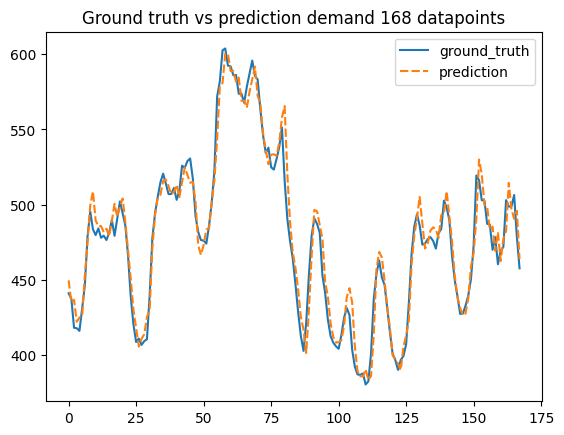

In [ ]:
plot_truth_vs_pred(y_test, y_test_forecast, number_to_plot = 168)

## Model Inference

In [ ]:
def week_demand_prediction(last_3_week_data):
  week_demand = []
  count = 0
  last_3_week_data = last_3_week_data.reshape((1, 504))
  while count < 24*7:
    pred = loaded_model.predict(last_3_week_data)
    last_3_week_data = np.concatenate((last_3_week_data[:, 1:], pred.reshape(1, -1)), axis=1)
    count += 1
    week_demand.append(float(pred))

  return week_demand


In [ ]:
last_3_week_data = train_data.tail(504)["Demand (MW)"].values
last_3_week_data

array([611.9, 575.1, 575.5, 582.4, 586. , 581.5, 595.8, 614.7, 646.8,
       627.5, 625. , 608.7, 595.9, 588.7, 568.5, 562.6, 573.5, 588.5,
       613. , 621.9, 612. , 606.3, 580.3, 551.6, 544.5, 529.1, 529.2,
       534.6, 536.3, 551.1, 580.5, 625. , 626.9, 634. , 655.7, 605.4,
       595.4, 590. , 576.9, 583.5, 583.7, 586.9, 616.3, 613.3, 621.7,
       602.3, 589.3, 567.5, 547.3, 552.3, 552.1, 561.2, 564.4, 580.1,
       623.1, 657.1, 672.3, 647.4, 646.7, 630. , 625.6, 605.7, 588. ,
       573.2, 572.1, 585.3, 616.5, 630.4, 631.8, 626.4, 616.4, 594.5,
       577.8, 573.1, 575.7, 567. , 569.8, 575.9, 581.6, 577.3, 573.9,
       556.4, 529.8, 517.6, 480. , 471.2, 467.9, 472.3, 529. , 498.7,
       536.6, 507.6, 513.6, 501.3, 488.7, 464.3, 453.5, 442.7, 446.2,
       435.2, 431.1, 439.3, 440.7, 455.2, 464.2, 470.9, 476. , 482.5,
       455.9, 430.1, 403.8, 394.9, 409.4, 460.6, 478.6, 492.1, 490.1,
       473.9, 475.8, 456.5, 448.4, 444.5, 452.2, 458.8, 472.8, 480.2,
       536.5, 564.2,

In [ ]:
next_week_forecast = week_demand_prediction(last_3_week_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
<ipython-input-132-d57107242d99>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  week_demand.append(float(pred))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapse

In [ ]:
len(last_3_week_data), len(next_week_forecast)

(504, 168)

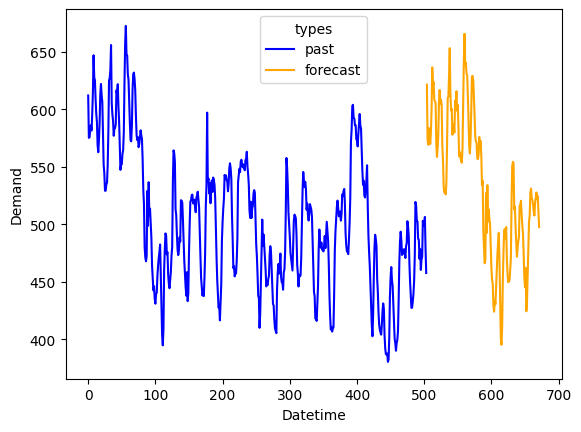

In [ ]:
colors = ['blue'] * len(last_3_week_data) + ['orange'] * len(next_week_forecast)
types = ['past'] * len(last_3_week_data) + ['forecast'] * len(next_week_forecast)

combined_demand_values = list(last_3_week_data) + list(next_week_forecast)

forecast_df = pd.DataFrame({"values" : combined_demand_values, "color" : colors, "types" : types})
plot = sns.lineplot(data = forecast_df, x = forecast_df.index, y="values", hue="types", palette = {"past" : "blue", "forecast": "orange"})
plt.ylabel("Demand")
plt.xlabel("Datetime")

plt.show()